# Cuff_Less Blood Pressure Estimation:

**Overview:**

<em style='color: red'>Blood pressure (BP)</em>, also referred to as <em style='color: red'>Arterial blood pressure (ABP)</em>, is the pressure exerted by circulating blood upon the walls of blood vessels.


The most common approach to measure Blood Pressure (BP) without clinical supervision is the automated BP cuff employing oscillometry. A cuff is wrapped around the upper arm and inflated above systolic pressure, then deflated to a pressure below diastolic BP. A pressure sensor inserted in the cuff records the arterial pulsations during the cuff deflation, and the amplitudes of these pulsations are used to calculate systolic and diastolic BP.

<div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Blood_pressure_monitoring.jpg/1920px-Blood_pressure_monitoring.jpg", height="100", width="500"/></div>


This approach has many limitations, the primary one being that it relies on a set of empirical coefficients to map the pulse amplitudes to systolic and diastolic BP. Most of these coefficients are specific to the device and can vary across devices.

Further, since it relies solely on pulse amplitudes, <strong> it fails to provide accurate readings in patients with atherosclerosis or obese patients whose pulse amplitudes can be weak</strong>.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**ElectroCardiogram (ECG)**

ECG or EKG check for signs of heart disease. It's a test that records the electrical activity of your ticker through small electrode patches that a technician attaches to the skin of your chest, arms, and legs.

An abnormal ECG can tell your doctor if you have any of these issues:


1.   irregular heartbeat (an arrhythmia)
2.   problems with the spread of electrical activity within the heart
3.   an enlarged heart
4.   areas of the heart with reduced blood supply
5.   a ‘silent’ heart attack (an interruption to blood flow in the     coronary arteries without usual heart attack symptoms).


<div><img src="https://ecglibrary.com/ecgs/norm_2x.png", height="100", width="500"/></div>

**PhotoPlethysmoGraph (PPG)**

A photoplethysmogram (PPG) is an optically obtained plethysmogram that can be used to detect blood volume changes in the microvascular bed of tissue. A PPG is often obtained by using a pulse oximeter which illuminates the skin and measures changes in light absorption.A conventional pulse oximeter monitors the perfusion of blood to the dermis and subcutaneous tissue of the skin.

A plethysmograph is an instrument for measuring changes in volume within an organ or whole body (usually resulting from fluctuations in the amount of blood or air it contains).

<div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Pulse_oximiter%2C_Photoplethysmograph.jpg/675px-Pulse_oximiter%2C_Photoplethysmograph.jpg", height="50", width="300"/></div>

**The dataset:**

The blood pressure dataset provides clean and valid signals for designing cuff-less blood pressure estimation algorithms.
The matlab files (.mat) contain raw electrocardiogram (ECG), photoplethysmograph (PPG), and arterial blood pressure (ABP) signals stored as [cell arrays](https://www.mathworks.com/help/matlab/ref/cell.html#:~:text=A%20cell%20array%20is%20a,indices%20in%20smooth%20parentheses%2C%20()%20.) of matrices where each cell is one record part.
In each matrix, each row corresponds to one signal channel:

1: PPG signal, FS=125Hz; photoplethysmograph from fingertip

2: ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)

3: ECG signal, FS=125Hz; electrocardiogram from channel II

Note: Each cell is a record. There might be more than one record per patient (which is not possible to distinguish). However, records of the same patient appear next to each other.
n-fold cross test and train is suggested to reduce the chance of train set being contaminated by test patients

## Data Analysis

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # doit afficher True
print(torch.cuda.get_device_name(0))  # doit afficher le nom de ton GPU


2.6.0+cu124
True
Tesla T4


[[](http://)[](http://)](http://)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
# os.listdir(r'C:\Users\hp\Desktop\dat\bloodpressure')

In [ ]:
import torch
print(torch.cuda.is_available())  # Affiche True si CUDA est disponible, sinon False


True


In [ ]:
import torchvision
import torchaudio
print(torch.__version__)  # Affiche la version de PyTorch
print(torchvision.__version__)  # Affiche la version de TorchVision
print(torchaudio.__version__)  # Affiche la version de Torchaudio


2.6.0+cu124
0.21.0+cu124
2.6.0+cu124


In [ ]:
import torch
print(torch.cuda.is_available())  # Devrait retourner True si CUDA est disponible
print(torch.cuda.device_count())  # Affiche le nombre de GPUs disponibles
print(torch.cuda.get_device_name(0))  # Affiche le nom du GPU


True
1
Tesla T4


In [ ]:
import torch
print(torch.__version__)


2.6.0+cu124


In [ ]:
# defining our evaluation error function
def rmse(y_true, y_pred):
    """Computes the Root Mean Squared Error (RMSE)."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
import os
print(os.path.exists("/content/drive/MyDrive/Colab Notebooks/part_1.mat"))
print(os.path.getsize("/content/drive/MyDrive/Colab Notebooks/part_1.mat"))


True
471767364


In [ ]:
!pip install scipy

In [ ]:
sample_file =scipy.io.loadmat("/content/drive/MyDrive/Colab Notebooks/part_1.mat")
print(f'sample_file Data type: {type(sample_file)}')
print(f'sample_file keys:\n{sample_file.keys()}')
signals = sample_file['p']
print(signals.shape)  # Pour vérifier la dimension des données


sample_file Data type: <class 'dict'>
sample_file keys:
dict_keys(['__header__', '__version__', '__globals__', 'p'])
(1, 1000)


In [ ]:
print(signals)

[[array([[ 1.75953079e+00,  1.71847507e+00,  1.68426197e+00, ...,
           1.64418377e+00,  1.60019550e+00,  1.56598240e+00],
         [ 6.70629552e+01,  6.93586281e+01,  7.53664529e+01, ...,
           7.64410232e+01,  8.18138747e+01,  9.13873191e+01],
         [-6.06060606e-02, -7.52688172e-02, -7.03812317e-02, ...,
          -1.00195503e-01, -9.04203324e-02, -4.54545455e-02]])
  array([[ 2.40957967,  2.32942326,  2.23851417, ...,  1.24046921,
           1.23069404,  1.21994135],
         [73.75459745, 73.1684682 , 72.53349484, ..., 99.15353167,
          96.22288542, 93.19455095],
         [ 0.18475073,  0.17986315,  0.16959922, ...,  0.29472141,
           0.31964809,  0.33968719]])
  array([[  1.21212121,   1.20136852,   1.19354839, ...,   1.34506354,
            1.33040078,   1.31671554],
         [ 94.80640639,  91.87576014,  88.55436105, ..., 127.38542394,
          124.16171306, 120.74262576],
         [  0.214565  ,   0.22482893,   0.23460411, ...,   0.31476051,
           

In [ ]:
# Extraire les trois lignes pour chaque élément de données
# Vérifier le contenu de la clé 'p'
p_data = sample_file['p']
print(type(p_data))  # Type des données sous 'p'
print(p_data.shape)  # Vérifie la forme des données


<class 'numpy.ndarray'>
(1, 1000)


In [ ]:
# Accéder à la seule séquence présente
signal_1 = p_data[0]

print(signal_1.shape)  # Devrait être (1000,)


(1000,)





























ce qui signifie qu'il y a 1000 points de données dans une seule séquence. Cela suggère qu'il s'agit d'une seule instance de signal (probablement un signal temporel, comme le PPG ou l'ECG, mais il faudrait vérifier).

In [ ]:
# import pandas as pd

# df = pd.read_csv(r"C:/Users/hp/Desktop/dat/bloodpressure/Samples/rec_6.csv")
# print(df.head())


Le fichier CSV semble contenir des séries temporelles avec des mesures à chaque point de temps. Chaque ligne représente probablement un instantané des valeurs mesurées pour des paramètres comme la pression artérielle systolique (SBP) et diastolique (DBP).

What's happening in the cell above?

* We use the `scipy.io.loadmat()` method to read our sample matlab(.mat) file and store it in the variable `sample_file`
    * The `scipy.io.loadmat()` method reads the matlab file and returns a `dict`/(dictionary) which is then stored back in the `sample_file` variable. To prove this, we print the data type of sample_file `type(sample_file)` as seen in line-2 and bingo it tells us its a `dict`
    
* A [dictionary](https://realpython.com/python-dicts/) is a [data structure](https://en.wikipedia.org/wiki/Data_structure#:~:text=In%20computer%20science%2C%20a%20data,be%20applied%20to%20the%20data.) that stores data in key, value pairs. For instance; {key1: value1, key2: value2}. What line-3 in the cell above does is to get and return the keys of the `sample_file` dictionary.

* Things to try out:
    * try displaying all contents of the `sample file` dictionary to see all its data (hint: just type sample file below the last print statement)
    * display only the values of the `sample file` dictionary (hint: replace `.keys() with .values()`)
    * load any other matlab file by substituting the value 1 with any other in the range (1-12) as there are only 12 files provided.

From  what we've seen above, we only need the values contained in the key `p` (photoplethysmograph or (PPG)). The other keys contain meta data that we won't need.
Therefore in all other cells I'll apply `['p']` at the end of the `.loadmat() method` to only read the values contained in the key `['p']`i.e `scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')['p']`

In [ ]:
# Loading a sample .mat file to understand the data dimensions
test_sample =scipy.io.loadmat("/content/drive/MyDrive/Colab Notebooks/part_1.mat")['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


So here's what's happening in the cell above:

* We use the `scipy.io.loadmat()` method to read our sample matlab(.mat) file and store it in the variable `test_sample`
    * The `scipy.io.loadmat()` method reads the matlab file and this time around returns a [numpy ndarray](https://numpy.org/doc/stable/reference/arrays.ndarray.html#:~:text=Quick%20search-,The%20N%2Ddimensional%20array%20(%20ndarray%20),the%20sizes%20of%20each%20dimension.) (because of the `['p']`)  which is then stored in the `test_sample` variable. To prove this, we print the data type of test_sample `type(test_sample)` as seen in line-2 and bingo it tells us its `numpy.ndarray` (nd means n-dimensional)
* Additionally, we check and print the size/dimensions of `test_sample` by running `test_sample.shape` and it prints out `(1,1000)`; <strong> this means the array contains 1 row and 1000 columns.</strong>

Things to try out:

* Load any other matlab file by substituting the value 1 with any other in the range (1-12) and re-run the cell (there are only 12 files provided.). You should get the same shape `(1,1000)`

* Print out the entire `test_sample` array and see what it contains. (Hint: use print(test_sample) or just type test_sample and run the cell). You should see an outer array and multiple inner arrays.i.e all files contain one row and 1000 columns where each column is itself an array.

* Try finding out the contents of each column and the size of each column (hint: accessing nested arrays)

In [ ]:
print(f"Total Samples: {len(test_sample[0])}")
print(f"Number of readings in each sample(column): {len(test_sample[0][0])}")
print(f"Number of samples in each reading(ECG): {len(test_sample[0][0][2])}")

temp_mat = test_sample[0, 999]
temp_length = temp_mat.shape[1]
sample_size = 125


print(temp_length)
print((int)(temp_length/sample_size))

Total Samples: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [ ]:
print(test_sample[0, 0].shape)  # Vérifie la forme de l'élément dans la première colonne


(3, 61000)


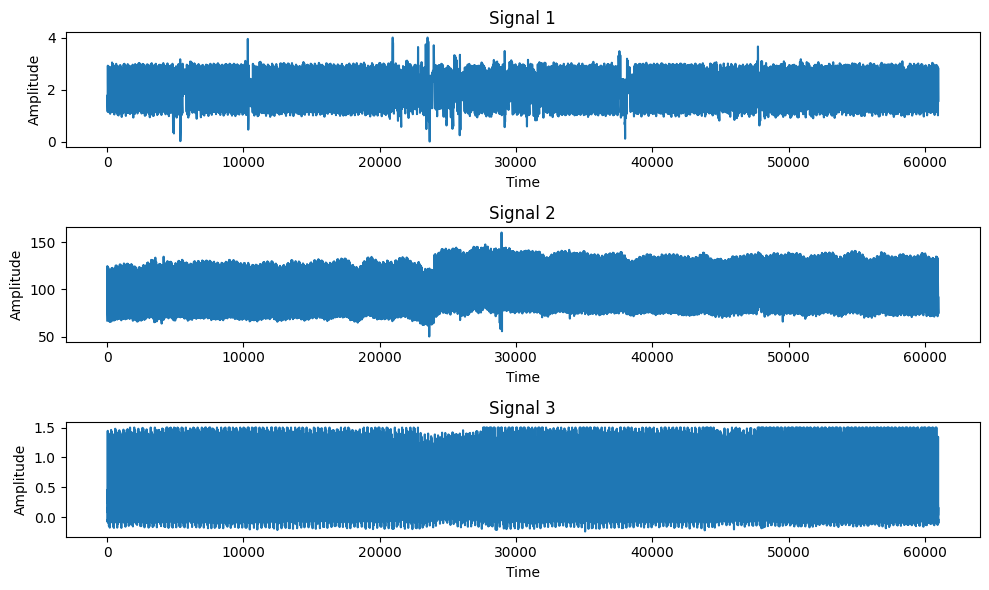

In [ ]:
import matplotlib.pyplot as plt

# Visualisation des 3 signaux (chaque ligne représente un signal)
plt.figure(figsize=(10, 6))

# Signal 1
plt.subplot(3, 1, 1)
plt.plot(test_sample[0, 0][0, :])  # Première ligne (signal 1)
plt.title('Signal 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Signal 2
plt.subplot(3, 1, 2)
plt.plot(test_sample[0, 0][1, :])  # Deuxième ligne (signal 2)
plt.title('Signal 2')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Signal 3
plt.subplot(3, 1, 3)
plt.plot(test_sample[0, 0][2, :])  # Troisième ligne (signal 3)
plt.title('Signal 3')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Calcul des statistiques pour les trois signaux
for i in range(3):
    signal = test_sample[0, 0][i, :]
    print(f"Signal {i + 1}:")
    print(f"  Mean: {np.mean(signal)}")
    print(f"  Std: {np.std(signal)}")
    print(f"  Min: {np.min(signal)}")
    print(f"  Max: {np.max(signal)}\n")


Signal 1:
  Mean: 1.8397406534942229
  Std: 0.6319763101737184
  Min: 0.0
  Max: 4.001955034213099

Signal 2:
  Mean: 94.65766488508467
  Std: 20.56653806501105
  Min: 50.16289508774844
  Max: 160.1109738049069

Signal 3:
  Mean: 0.2258416822909155
  Std: 0.2546555174886905
  Min: -0.2404692082111437
  Max: 1.5009775171065494



Signal 1 : PPG (Photoplethysmogramme)

Ce signal semble correspondre à un signal PPG typique mesurant les variations du volume sanguin.

Signal 2 : ABP (Pression artérielle invasive)

Les valeurs de pression artérielle mesurées par ABP sont cohérentes avec celles observées dans ce signal.

Signal 3 : ECG (Électrocardiogramme)

Ce signal correspond à un ECG qui mesure les impulsions électriques du cœur.

Correlation Matrix:
[[ 1.         -0.54784458 -0.22995307]
 [-0.54784458  1.          0.16852359]
 [-0.22995307  0.16852359  1.        ]]


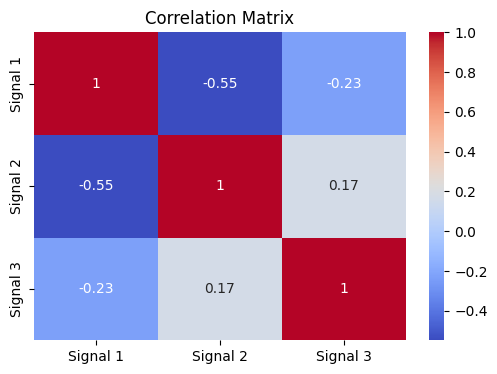

In [ ]:
# Calcul de la corrélation entre les signaux
corr_matrix = np.corrcoef(test_sample[0, 0])
print("Correlation Matrix:")
print(corr_matrix)

# Visualisation de la corrélation sous forme de heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=["Signal 1", "Signal 2", "Signal 3"], yticklabels=["Signal 1", "Signal 2", "Signal 3"])
plt.title('Correlation Matrix')
plt.show()


Le signal 1 et signal 2 ont une corrélation négative modérée de -0.5478. Cela suggère qu'ils mesurent probablement des phénomènes physiologiques opposés, ce qui est souvent le cas entre des signaux comme le PPG (Photoplethysmogramme) et l'ABP (Arterial Blood Pressure). Par exemple, les variations du volume sanguin mesurées par le PPG peuvent être inversées par rapport aux variations de pression artérielle mesurées par l'ABP.

Le signal 1 et signal 3 ont une faible corrélation négative de -0.2299, ce qui pourrait indiquer que le PPG et l'ECG ne sont pas fortement liés dans ce cas précis. Cependant, il peut y avoir des relations indirectes ou des liens physiologiques, mais la corrélation ici est faible.

Le signal 2 et signal 3 ont une très faible corrélation positive de 0.1685, ce qui suggère que l'ABP et l'ECG ne sont que faiblement liés dans ce contexte. Cela est aussi attendu, car bien que ces signaux mesurent différents aspects de la physiologie cardiaque (pression artérielle pour ABP et activité électrique du cœur pour ECG), leurs relations directes sont faibles.

Conclusion probable :
En fonction de ces corrélations et des informations communes pour des jeux de données similaires, il est probable que les signaux suivent cet ordre :

Signal 1 : PPG (Photoplethysmogramme)

Signal 2 : ABP (Pression artérielle invasive)

Signal 3 : ECG (Électrocardiogramme)

In [ ]:
sample_size = 125
ppg = []
for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]
        ppg.append(temp_ppg)

<a id='sbp_cell'></a>
In the cell below, I extract BP and ECG signals from the mat file and store them in an array/list.
* I additionally extract Systolic blood pressure(SBP) and Diastolic Blood pressure(DBP) from the BP signal.

* `systole` and `diastole` are two phases of a heart beat. `BP` <strong>increases</strong> as the heart muscle contracts during `systole`, where blood is pushed towards the periphery of the body and it <strong>decreases</strong> when the heart relaxes to fill with blood during the `diastole`. Hence we take `max(BP)` to derive `SBP` and `min(BP)` to get `DBP`. refer to [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6696196/) for more insight.

In [ ]:
print(len(ppg))

256488


Nombre total de segments ECG: 256488
Nombre total de segments de pression artérielle: 256488
Nombre total de valeurs de SBP: 256488
Nombre total de valeurs de DBP: 256488


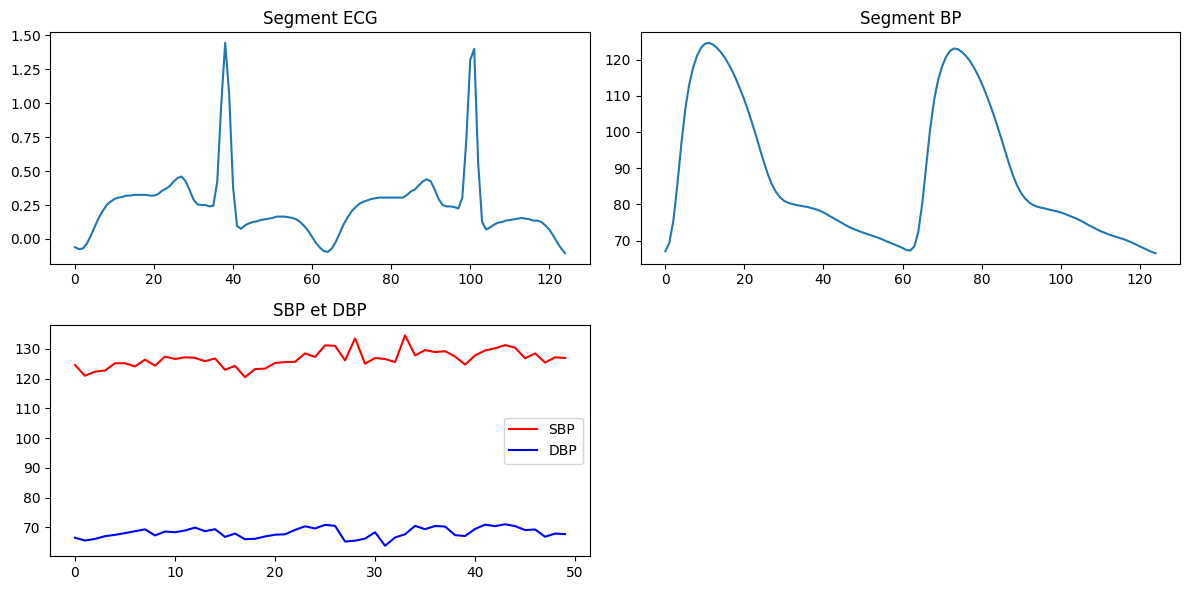

In [ ]:
import matplotlib.pyplot as plt

# Initialisation des listes
ecg = []
bp = []
sbp = []
dbp = []
size = 125  # taille de l'échantillon

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    num_segments = temp_length // size  # Calcul du nombre de segments

    for j in range(num_segments):
        temp_ecg = temp_mat[2, j*size:(j+1)*size]
        temp_bp = temp_mat[1, j*size:(j+1)*size]

        # Calcul des valeurs de SBP et DBP
        max_value = max(temp_bp)
        min_value = min(temp_bp)

        sbp.append(max_value)
        dbp.append(min_value)
        ecg.append(temp_ecg)
        bp.append(temp_bp)

# Vérification des dimensions des listes
print(f"Nombre total de segments ECG: {len(ecg)}")
print(f"Nombre total de segments de pression artérielle: {len(bp)}")
print(f"Nombre total de valeurs de SBP: {len(sbp)}")
print(f"Nombre total de valeurs de DBP: {len(dbp)}")

# Visualisation de quelques segments
plt.figure(figsize=(12, 6))

# Tracer un segment ECG
plt.subplot(2, 2, 1)
plt.plot(ecg[0])
plt.title("Segment ECG")

# Tracer un segment de pression artérielle (BP)
plt.subplot(2, 2, 2)
plt.plot(bp[0])
plt.title("Segment BP")

# Tracer les valeurs de SBP et DBP
plt.subplot(2, 2, 3)
plt.plot(sbp[:50], label='SBP', color='r')
plt.plot(dbp[:50], label='DBP', color='b')
plt.legend()
plt.title("SBP et DBP")

plt.tight_layout()
plt.show()


Nombre de segments par signal :
61000/125=488

In [ ]:
# Reshaping the ecg, ppg and bp signal data into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


In [ ]:
print("Length of ppg:", len(ppg))
print("Length of ecg:", len(ecg))
print("Length of bp:", len(bp))


Length of ppg: 32061000
Length of ecg: 32061000
Length of bp: 32061000


In [ ]:
# ppg_full = np.concatenate(ppg).reshape(-1, 1)
# ecg_full = np.concatenate(ecg).reshape(-1, 1)
# bp_full  = np.concatenate(bp).reshape(-1, 1)

# sample_size = 125

# # Convert to (N, ) shape
# ppg_full = ppg_full.reshape(-1)
# ecg_full = ecg_full.reshape(-1)
# bp_full  = bp_full.reshape(-1)

# # Découper le signal en segments complets
# num_segments = len(ppg_full) // sample_size

# # Tronquer les valeurs restantes à la fin
# ppg_segments = ppg_full[:num_segments * sample_size].reshape(num_segments, sample_size)
# ecg_segments = ecg_full[:num_segments * sample_size].reshape(num_segments, sample_size)
# bp_segments  = bp_full[:num_segments * sample_size].reshape(num_segments, sample_size)
# print(ppg_segments.shape)  # ➜ (256488, 125)
# print(ecg_segments.shape)
# print(bp_segments.shape)
# print(np.array(sbp).shape)

Vous avez 256,488 segments pour chaque signal (ppg, ecg, et bp), et chaque segment contient 125 valeurs.

La pression systolique (sbp) est représentée par une seule valeur pour chaque instant, soit 256,488 valeurs au total.

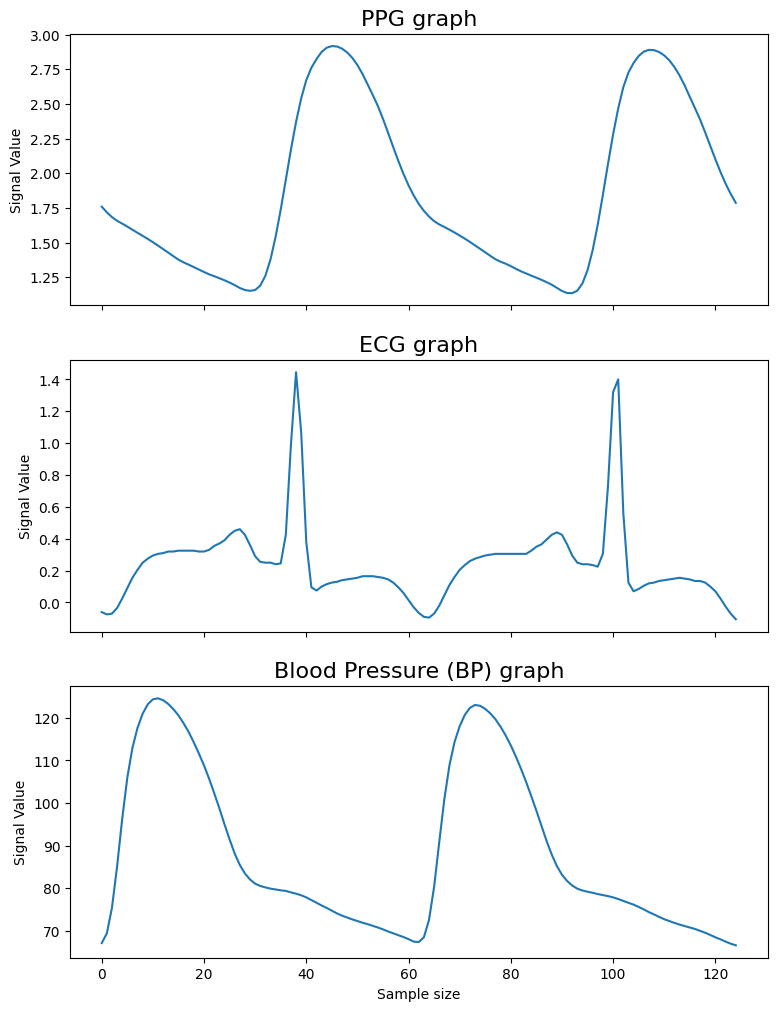

In [ ]:
##plotting sample ppg, ecg and bp signals
##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:125])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:125])

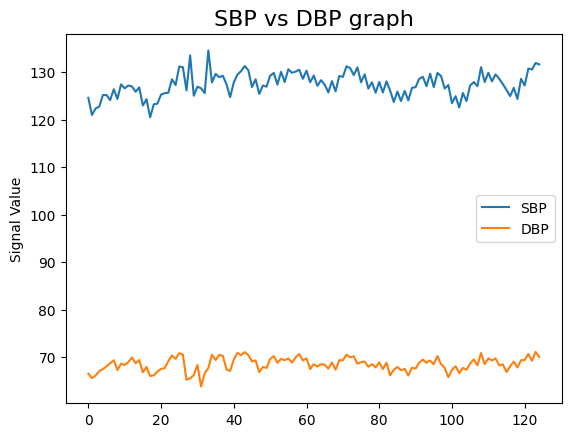

In [ ]:
## Visualizing SBP and DBP
#fig, ax = plt.subplots(1,1, figsize=(9,12))

plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])

It can be seen from above that `SBP` is higher than `DBP` as was explained [earlier](#sbp_cell)

### Statistical Correlation of signals


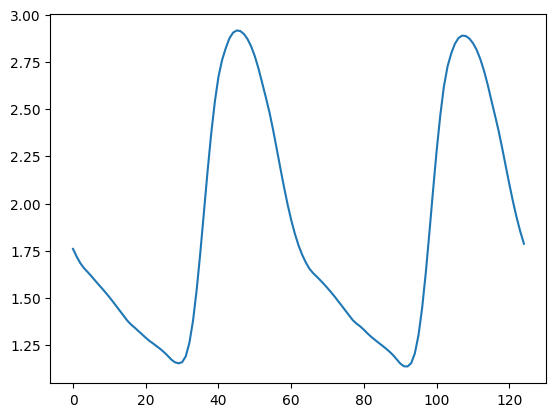

In [ ]:
plt.plot(ppg[:125].squeeze())

### Computing and Visualizing the Cross correlation of PPG and BP signals

[Cross correlation](https://en.wikipedia.org/wiki/Cross-correlation#:~:text=In%20signal%20processing%2C%20cross%2Dcorrelation,for%20a%20shorter%2C%20known%20feature.) is where two signals are compared inorder to produce a third signal that shows the similarity between the two signals compared. It can be used to create plots that may reveal hidden sequences.


La corrélation croisée entre les signaux PPG et BP peut être calculée pour comprendre la relation entre les variations des deux signaux. La corrélation croisée mesure à quel point deux séries temporelles sont similaires l'une par rapport à l'autre à différents décalages temporels (lags)

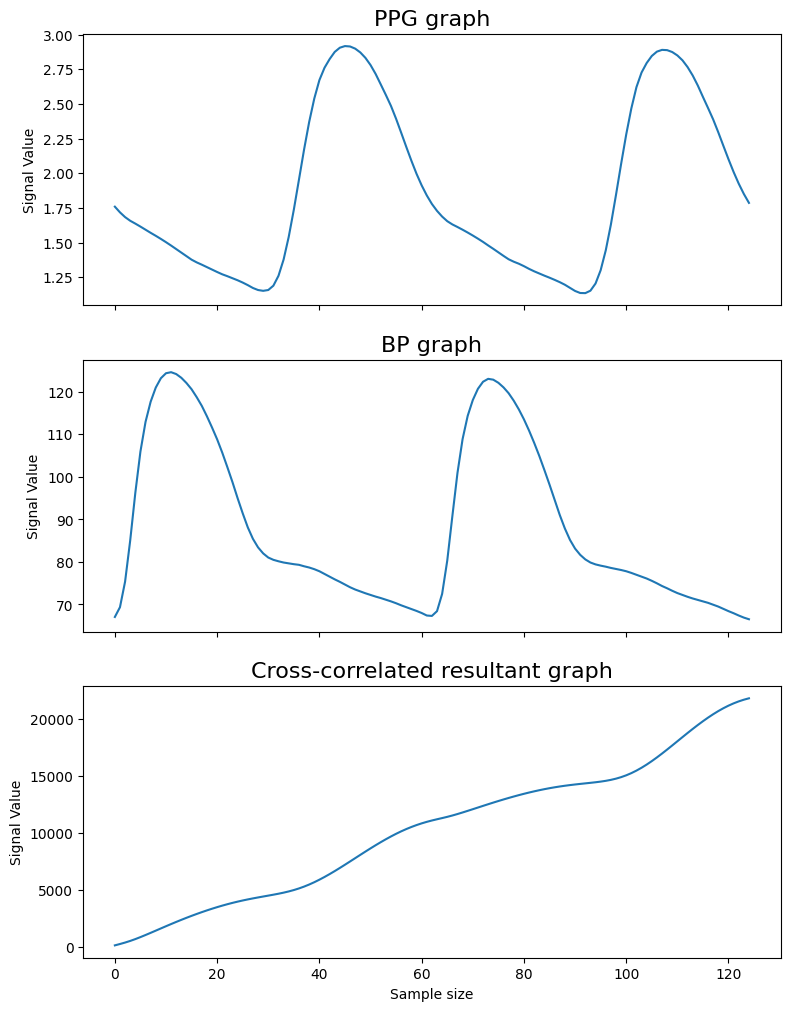

In [ ]:
# Computing the cross correlation of ppg and bp signals
cross_corr = np.convolve(ppg[:125].squeeze(), bp[:125].squeeze(), mode='full')

fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('BP graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:125])

ax[2].set_title('Cross-correlated resultant graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(cross_corr[:125])

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# =============================
# Paramètres
# =============================
sample_size = 125  # taille de chaque segment (par ex. 1 seconde si 125 Hz)
signals = test_sample[0]  # tu peux remplacer par ton tableau de signaux

# =============================
# Segmentation des données
# =============================
ppg_segments = []
ecg_segments = []
bp_segments = []
sbp_values = []
dbp_values = []

for i in range(len(signals)):
    signal = signals[i]  # shape: (3, L)
    length = signal.shape[1]
    num_segments = length // sample_size

    for j in range(num_segments):
        start = j * sample_size
        end = (j + 1) * sample_size

        ppg_seg = signal[0, start:end]
        bp_seg = signal[1, start:end]
        ecg_seg = signal[2, start:end]

        sbp = np.max(bp_seg)
        dbp = np.min(bp_seg)

        # Append to lists
        ppg_segments.append(ppg_seg)
        bp_segments.append(bp_seg)
        ecg_segments.append(ecg_seg)
        sbp_values.append(sbp)
        dbp_values.append(dbp)

# =============================
# Conversion en tenseurs PyTorch
# =============================
X = torch.tensor(np.stack([ppg_segments, ecg_segments], axis=1), dtype=torch.float32)  # shape: (N, 2, 125)
y = torch.tensor(np.stack([sbp_values, dbp_values], axis=1), dtype=torch.float32)      # shape: (N, 2)

print(f"Input shape (X): {X.shape}")  # Ex: (256488, 2, 125)
print(f"Target shape (y): {y.shape}")  # Ex: (256488, 2)


Input shape (X): torch.Size([256488, 2, 125])
Target shape (y): torch.Size([256488, 2])


test_sample[0] contient des signaux multi-canaux (PPG, BP, ECG).

Pour chaque patient ou échantillon : signal[i] a la forme (3, L) → 3 signaux (PPG, BP, ECG).

Chaque signal est découpé en segments de 125 points.

Pour chaque segment :

Tu récupères :

PPG: signal[0]

BP: signal[1]

ECG: signal[2]

Puis, tu stockes :

ppg_seg, bp_seg, ecg_seg

sbp = max(bp_seg), dbp = min(bp_seg)

X aura la forme : (N, 2, 125) → 2 canaux (PPG, ECG) sur 125 points.

y aura la forme : (N, 2) → 2 valeurs à prédire : SBP et DBP.

In [ ]:
# from torch.utils.data import Dataset

# class BP_Dataset(Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]


Création d’une classe Dataset personnalisée pour charger les données segmentées.

DataLoader les utilisera ensuite pour le batch training.

In [ ]:
# from torch.utils.data import DataLoader

# dataset = BP_Dataset(X, y)
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# import torch.nn as nn

# class BPTransformer(nn.Module):
#     def __init__(self, input_dim=2, seq_len=125, d_model=128, nhead=4, num_layers=2):
#         super().__init__()
#         self.embedding = nn.Linear(input_dim, d_model)  # Convertir (2, 125) → (125, d_model)
#         encoder_layer = nn.TransformerEncoderLayer(
#                     d_model=d_model, nhead=nhead, dropout=0.1, batch_first=True)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.pool = nn.AdaptiveAvgPool1d(1)
#         self.fc = nn.Linear(d_model, 2)  # prédire SBP et DBP


#     def forward(self, x):
#         # x shape: (batch_size, 2, 125) → transpose for sequence first
#         x = x.transpose(1, 2)  # (batch, 125, 2)
#         x = self.embedding(x)  # (batch, 125, d_model)
#         x = self.transformer(x)  # (batch, 125, d_model)
#         x = x.mean(dim=1)  # Pooling sur la séquence
#         output = self.fc(x)  # (batch, 2)
#         return output


In [ ]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # 1. Vérifier si CUDA (GPU) est disponible
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # 2. Définir le modèle et le déplacer vers le device (GPU ou CPU)
# model = BPTransformer().to(device)

# # 3. Définir la fonction de perte (Loss) et l'optimiseur
# criterion = nn.SmoothL1Loss()  # Utilisation de la perte Huber (SmoothL1Loss)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

# # 4. Initialisation du scheduler ReduceLROnPlateau
# scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

# # 5. Boucle d'entraînement avec GPU
# for epoch in range(70):
#     model.train()  # Passer le modèle en mode entraînement
#     total_loss = 0.0

#     for X_batch, y_batch in train_loader:
#         # Déplacer les batchs vers le device (GPU ou CPU)
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         # Propagation avant (forward)
#         output = model(X_batch)
#         loss = criterion(output, y_batch)

#         # Rétropropagation (backward)
#         optimizer.zero_grad()  # Réinitialiser les gradients
#         loss.backward()  # Calculer les gradients
#         optimizer.step()  # Mettre à jour les poids

#         total_loss += loss.item()  # Ajouter la perte de ce batch

#     avg_loss = total_loss / len(train_loader)  # Calcul de la perte moyenne pour cette époque
#     print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

#     # Appliquer le scheduler après chaque époque
#     scheduler.step(avg_loss)  # Réduit le taux d'apprentissage si la perte stagne

In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

# # Assurer que le modèle est sur le CPU
# device = torch.device('cpu')
# model.to(device)
# model.eval()

# # Créer DataLoader pour les données de test
# batch_size = 64  # Tu peux ajuster ce nombre (plus petit si tu as peu de RAM)

# # S'assurer que X_test et y_test sont des torch tensors
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

# # Créer un dataset en associant X_test et y_test
# test_dataset = TensorDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

# all_preds = []

# with torch.no_grad():
#     for batch in test_loader:
#         inputs, labels = batch  # Extraction des inputs et labels
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = model(inputs)
#         all_preds.append(outputs.cpu())

# # Concaténer toutes les prédictions
# predictions = torch.cat(all_preds, dim=0).numpy()

# # Évaluer les performances
# from sklearn.metrics import mean_squared_error, r2_score
# mse = mean_squared_error(y_test.numpy(), predictions)
# r2 = r2_score(y_test.numpy(), predictions)

# print(f"Mean Squared Error (MSE): {mse:.4f}")
# print(f"R-squared (R²): {r2:.4f}")


In [ ]:
# !pip install tsai


In [ ]:
# # ==== PyTorch ====
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset
# import numpy as np

# # ==== tsai ====
# from tsai.all import get_ts_dls, PatchTST, Learner, mae, mse, rmse, R2Score, TSRegression

# # ==== sklearn ====
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # ==================== Dataset PyTorch ====================

# class BP_Dataset(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.tensor(X, dtype=torch.float32)
#         self.y = torch.tensor(y, dtype=torch.float32)

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# dataset = BP_Dataset(X, y)
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# # ==================== Vanilla Transformer ====================

# class BPTransformer(nn.Module):
#     def __init__(self, input_dim=2, seq_len=125, d_model=128, nhead=4, num_layers=2):
#         super().__init__()
#         self.embedding = nn.Linear(input_dim, d_model)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model, nhead=nhead, dropout=0.1, batch_first=True)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.fc = nn.Linear(d_model, 2)

#     def forward(self, x):
#         x = x.transpose(1, 2)
#         x = self.embedding(x)
#         x = self.transformer(x)
#         x = x.mean(dim=1)
#         return self.fc(x)

# # ==================== Entraînement Vanilla Transformer ====================

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_vanilla = BPTransformer().to(device)
# criterion = nn.SmoothL1Loss()
# optimizer = optim.Adam(model_vanilla.parameters(), lr=2e-4)

# print("\n🚀 Training Vanilla Transformer...\n")
# for epoch in range(70):
#     model_vanilla.train()
#     total_loss = 0

#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)

#         optimizer.zero_grad()
#         output = model_vanilla(X_batch)
#         loss = criterion(output, y_batch)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_loader)
#     print(f"[Vanilla] Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# # ==================== Évaluation Vanilla ====================

# model_vanilla.eval()
# predictions = []
# true_labels = []

# with torch.no_grad():
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         output = model_vanilla(X_batch)
#         predictions.append(output.cpu().numpy())
#         true_labels.append(y_batch.numpy())

# pred_vanilla = np.concatenate(predictions, axis=0)
# true_vanilla = np.concatenate(true_labels, axis=0)



In [ ]:
X.shape

torch.Size([256488, 2, 125])

In [ ]:
y.shape

torch.Size([256488, 2])

In [ ]:
# /*************  ✨ Windsurf Command ⭐  *************/
# X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# /*******  b582232c-1a44-4fe9-844b-b3ba844917ac  *******/

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_y = StandardScaler()

# X_scaled = scaler.fit_transform(X)
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# X_val_scaled = scaler.transform(X_test)
Y_scaled = scaler_y.fit_transform(y)
# Y_val_scaled = scaler_y.transform(y_test)



In [ ]:
class BloodPressureDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Création du DataLoader
dataset = BloodPressureDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# import torch.nn as nn

# class PatchTST(nn.Module):
#     def __init__(self, input_channels=2, seq_len=125, patch_len=25, d_model=64, n_heads=4, num_layers=2, dropout=0.1):
#         super(PatchTST, self).__init__()
#         self.patch_len = patch_len
#         self.seq_len = seq_len
#         self.n_patches = seq_len // patch_len

#         self.embedding = nn.Linear(patch_len, d_model)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.fc = nn.Linear(d_model * input_channels * self.n_patches, 128)  # Prédire SBP et DBP
#         self.fc1 = nn.Linear(128, 2)  # Prédire SBP et DBP

#     def forward(self, x):
#         # x: (batch_size, channels, seq_len)
#         batch_size, channels, seq_len = x.size()
#         x = x.view(batch_size * channels, self.n_patches, self.patch_len)
#         x = self.embedding(x)  # (batch_size * channels, n_patches, d_model)
#         x = x.permute(1, 0, 2)  # (n_patches, batch_size * channels, d_model)
#         x = self.transformer(x)
#         x = x.permute(1, 0, 2).contiguous().view(batch_size, -1)
#         out = self.fc(x)
#         out = self.fc1(out)
#         return out


In [ ]:
# # /*************  ✨ Windsurf Command ⭐  *************/
# import torch.nn as nn

# class PatchTST(nn.Module):
#     def __init__(self, input_channels=2, seq_len=125, patch_len=25, d_model=64, n_heads=4, num_layers=2, dropout=0.1):
#         super(PatchTST, self).__init__()
#         self.patch_len = patch_len
#         self.seq_len = seq_len
#         self.n_patches = seq_len // patch_len

#         self.embedding = nn.Linear(input_channels * patch_len, d_model)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.fc = nn.Linear(d_model * self.n_patches, 128)
#         self.fc1 = nn.Linear(128, 2)

#     def forward(self, x):
#         # x: (batch_size, seq_len, input_channels)
#         batch_size, seq_len, _ = x.size()
#         x = x.view(batch_size, self.n_patches, -1)  # (batch_size, n_patches, input_channels * patch_len)
#         x = self.embedding(x)  # (batch_size, n_patches, d_model)
#         x = x.permute(1, 0, 2)  # (n_patches, batch_size, d_model)
#         x = self.transformer(x)
#         x = x.permute(1, 0, 2).contiguous().view(batch_size, -1)
#         out = self.fc(x)
#         out = self.fc1(out)
#         return out

# # /*******  69bce34e-5eab-4cec-847d-8feb669c802b  *******/

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import random_split, DataLoader
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# import numpy as np

# # ⚠️ Remplace ceci par ton vrai dataset et modèle
# # from ton_module import dataset, PatchTST

# # Suppose que tu as déjà un dataset complet
# dataset_size = len(dataset)
# val_size = int(0.2 * dataset_size)  # 20% pour la validation
# train_size = dataset_size - val_size

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = PatchTST().to(device)

# # ✅ Fonction de perte HuberLoss
# criterion = nn.HuberLoss(delta=1.0)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # ✅ Scheduler dynamique
# # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


# # ✅ Early Stopping
# class EarlyStopping:
#     def __init__(self, patience=10, min_delta=0.0):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_loss = np.inf
#         self.early_stop = False

#     def __call__(self, val_loss):
#         if val_loss < self.best_loss - self.min_delta:
#             self.best_loss = val_loss
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True

# early_stopping = EarlyStopping(patience=10, min_delta=1e-4)



Epoch [1/2], Train Loss: 0.3426, Val Loss: 0.3008, LR: 0.001000
Epoch [2/2], Train Loss: 0.2888, Val Loss: 0.2605, LR: 0.001000


In [ ]:

# # 🔁 Boucle d'entraînement
# n_epochs = 50
# train_losses = []
# val_losses = []

# for epoch in range(n_epochs):
#     model.train()
#     running_loss = 0.0

#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()

#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     train_loss = running_loss / len(train_loader)
#     train_losses.append(train_loss)

#     # 🔍 Validation
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for X_val, y_val in val_loader:
#             X_val, y_val = X_val.to(device).float(), y_val.to(device).float()
#             val_outputs = model(X_val)
#             v_loss = criterion(val_outputs, y_val)
#             val_loss += v_loss.item()

#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)

#     # ✅ Scheduler et EarlyStopping
#     scheduler.step(val_loss)
#     early_stopping(val_loss)

#     # 📊 Affichage
#     current_lr = optimizer.param_groups[0]['lr']
#     print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

#     # ⏹️ Arrêt anticipé si nécessaire
#     if early_stopping.early_stop:
#         print(f"Early stopping at epoch {epoch+1}")
#         break

Epoch [1/50], Train Loss: 0.1214, Val Loss: 0.1119, LR: 0.001000


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model

# Exemple de formes
input_shape = (625, 2)  # Si tu utilises uniquement ECG + PPG
output_shape = 3        # SBP, DBP, MBP

# --- CNN-LSTM Model ---
def build_cnn_lstm_model():
    inputs = Input(shape=input_shape)

    # Convolutional block
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # LSTM block
    x = LSTM(64, return_sequences=False)(x)

    # Fully connected output
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_shape)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_cnn_lstm_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 625, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 625, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 312, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 312, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 156, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,915 (308.26 KB)

 Trainable params: 78,915 (308.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import torch.nn as nn

class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=3, padding=1),  # (2 → 32)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                # 125 → 62
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)                 # 62 → 31
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, 2)  # prédire 2 valeurs

    def forward(self, x):
        x = self.cnn(x)               # [batch, 64, 31]
        x = x.permute(0, 2, 1)        # [batch, 31, 64]
        x, _ = self.lstm(x)           # [batch, 31, 50]
        x = x[:, -1, :]               # Dernière sortie
        out = self.fc(x)              # [batch, 2]
        return out

In [ ]:
import torch.optim as optim

model = CNNLSTM().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from torch.utils.data import random_split, DataLoader
dataset_size = len(dataset)

val_size = int(0.2 * dataset_size)  # 20% pour la validation
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau




scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# ✅ Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

In [ ]:

# === 4. Entraînement ===
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()


    # ✅ Scheduler et EarlyStopping
    scheduler.step(val_loss)
    early_stopping(val_loss)

    # ✅ Scheduler et EarlyStopping
    scheduler.step(val_loss)
    early_stopping(val_loss)

    # 📊 Affichage
    current_lr = optimizer.param_groups[0]['lr']
    # print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

    # ⏹️ Arrêt anticipé si nécessaire
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# === 5. Évaluation (optionnelle) ===
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = model(xb).cpu()
        y_true.append(yb)
        y_pred.append(pred)

y_true = torch.cat(y_true, dim=0)
y_pred = torch.cat(y_pred, dim=0)

mse = mean_squared_error(y_true, y_pred)
print(f"Validation MSE: {mse:.4f}")

Early stopping at epoch 1
Validation MSE: 62.6339


In [ ]:
# /*************  ✨ Windsurf Command ⭐  *************/
# # Ensure that input data and model parameters have the same dtype
# X_batch = X_batch.to(device).float()  # Cast inputs to float
# outputs = model(X_batch)  # Outputs will automatically be of float dtype

# /*******  fc364cc4-e505-4012-a5c0-aa06c8259cf7  *******/

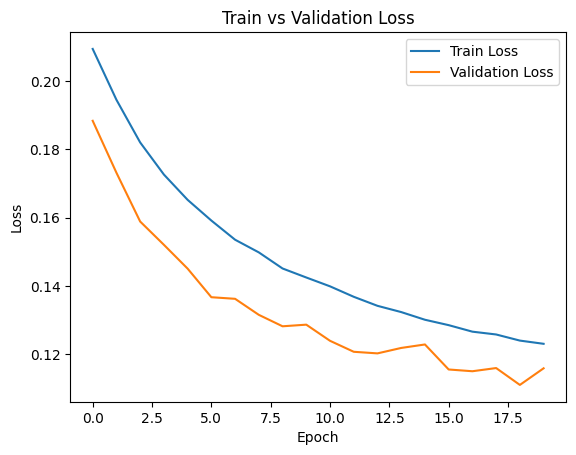

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

In [ ]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        outputs = model(X_batch)

        all_preds.append(outputs.cpu())
        all_targets.append(y_batch.cpu())

# Concatenation des prédictions et cibles
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Calcul des métriques
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(all_targets, all_preds)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print("\n--- Test Metrics ---")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error): {mse:.4f}")
print(f"R²   (R-squared Score): {r2:.4f}")



--- Test Metrics ---
MAE  (Mean Absolute Error): 4.8478
MSE  (Mean Squared Error): 52.0322
R²   (R-squared Score): 0.7957


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/cnn_lstm_model_weights.pt')

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import random_split, DataLoader
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# class PatchTST(nn.Module):
#     def __init__(self, input_channels=2, seq_len=125, patch_len=25, d_model=64, n_heads=4, num_layers=2, dropout=0.1):
#         super(PatchTST, self).__init__()
#         self.patch_len = patch_len
#         self.seq_len = seq_len
#         self.n_patches = seq_len // patch_len

#         self.embedding = nn.Sequential(
#             nn.Linear(patch_len, d_model),
#             nn.LayerNorm(d_model)
#         )

#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model,
#             nhead=n_heads,
#             dropout=dropout,
#             activation='gelu'
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.norm = nn.LayerNorm(d_model)
#         self.fc = nn.Linear(d_model * input_channels * self.n_patches, 2)

#         self._init_weights()

#     def _init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)

#     def forward(self, x):
#         batch_size, channels, seq_len = x.size()
#         x = x.view(batch_size * channels, self.n_patches, self.patch_len)
#         x = self.embedding(x)
#         x = x.permute(1, 0, 2)
#         x = self.transformer(x)
#         x = self.norm(x)
#         x = x.permute(1, 0, 2).contiguous().view(batch_size, -1)
#         out = self.fc(x)
#         return out

# # ⚠️ Remplacer par ton vrai dataset
# # from ton_module import dataset
# dataset_size = len(dataset)
# val_size = int(0.2 * dataset_size)
# train_size = dataset_size - val_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = PatchTST().to(device)

# criterion = nn.HuberLoss(delta=1.0)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# # ✅ Early Stopping parameters
# early_stopping_patience = 10
# best_val_loss = float("inf")
# epochs_without_improvement = 0

# n_epochs = 160
# train_losses, val_losses = [], []

# for epoch in range(n_epochs):
#     model.train()
#     running_loss = 0.0

#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)

#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         running_loss += loss.item()

#     train_loss = running_loss / len(train_loader)
#     train_losses.append(train_loss)

#     # 🔍 Validation
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for X_val, y_val in val_loader:
#             X_val, y_val = X_val.to(device), y_val.to(device)
#             val_outputs = model(X_val)
#             v_loss = criterion(val_outputs, y_val)
#             val_loss += v_loss.item()
#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)

#     scheduler.step(val_loss)
#     current_lr = optimizer.param_groups[0]['lr']
#     print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

#     # ✅ Early stopping logic
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         epochs_without_improvement = 0
#         best_model_state = model.state_dict()
#     else:
#         epochs_without_improvement += 1
#         if epochs_without_improvement >= early_stopping_patience:
#             print(f"⏹️ Early stopping triggered after {epoch+1} epochs.")
#             break

# # ✅ Charger les meilleurs poids
# model.load_state_dict(best_model_state)


Epoch [1/160], Train Loss: 11.7099, Val Loss: 10.6485, LR: 0.001000
Epoch [2/160], Train Loss: 9.9084, Val Loss: 10.0767, LR: 0.001000
Epoch [3/160], Train Loss: 9.4402, Val Loss: 9.0735, LR: 0.001000
Epoch [4/160], Train Loss: 9.0430, Val Loss: 9.0486, LR: 0.001000
Epoch [5/160], Train Loss: 8.7154, Val Loss: 8.5433, LR: 0.001000
Epoch [6/160], Train Loss: 8.4497, Val Loss: 8.2891, LR: 0.001000
Epoch [7/160], Train Loss: 8.2427, Val Loss: 8.4095, LR: 0.001000
Epoch [8/160], Train Loss: 8.0535, Val Loss: 7.8806, LR: 0.001000
Epoch [9/160], Train Loss: 7.8512, Val Loss: 8.0310, LR: 0.001000
Epoch [11/160], Train Loss: 7.5138, Val Loss: 7.6992, LR: 0.001000
Epoch [12/160], Train Loss: 7.3557, Val Loss: 7.4319, LR: 0.001000
Epoch [13/160], Train Loss: 7.2037, Val Loss: 7.0078, LR: 0.001000
Epoch [14/160], Train Loss: 7.0657, Val Loss: 6.8272, LR: 0.001000
Epoch [15/160], Train Loss: 6.9373, Val Loss: 6.6345, LR: 0.001000
Epoch [16/160], Train Loss: 6.8351, Val Loss: 6.7113, LR: 0.001000
E

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Train vs Validation Loss')
# plt.show()


In [ ]:
# model.eval()
# all_preds = []
# all_targets = []

# with torch.no_grad():
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         outputs = model(X_batch)

#         all_preds.append(outputs.cpu())
#         all_targets.append(y_batch.cpu())

# # Concatenation des prédictions et cibles
# all_preds = torch.cat(all_preds, dim=0).numpy()
# all_targets = torch.cat(all_targets, dim=0).numpy()

# # Calcul des métriques
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# mse = mean_squared_error(all_targets, all_preds)
# mae = mean_absolute_error(all_targets, all_preds)
# r2 = r2_score(all_targets, all_preds)

# print("\n--- Test Metrics ---")
# print(f"MAE  (Mean Absolute Error): {mae:.4f}")
# print(f"MSE  (Mean Squared Error): {mse:.4f}")
# print(f"R²   (R-squared Score): {r2:.4f}")


In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import random_split, DataLoader
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # ⚠️ Remplace ceci par ton vrai dataset et modèle
# # from ton_module import dataset, PatchTST

# # Suppose que tu as déjà un dataset complet
# dataset_size = len(dataset)
# val_size = int(0.2 * dataset_size)  # 20% pour la validation
# train_size = dataset_size - val_size

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = PatchTST().to(device)

# # ✅ Fonction de perte HuberLoss
# criterion = nn.HuberLoss(delta=1.0)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # ✅ Scheduler : réduit le LR quand val_loss stagne
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# # 🔁 Boucle d'entraînement
# n_epochs = 160
# train_losses = []
# val_losses = []

# for epoch in range(n_epochs):
#     model.train()
#     running_loss = 0.0

#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)

#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     train_loss = running_loss / len(train_loader)
#     train_losses.append(train_loss)

#     # 🔍 Validation
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for X_val, y_val in val_loader:
#             X_val, y_val = X_val.to(device), y_val.to(device)
#             val_outputs = model(X_val)
#             v_loss = criterion(val_outputs, y_val)
#             val_loss += v_loss.item()

#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)

#     # ✅ Mise à jour du scheduler
#     scheduler.step(val_loss)

#     # 📊 Affichage de l'état
#     current_lr = optimizer.param_groups[0]['lr']
#     print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")


Epoch [1/160], Train Loss: 11.4438, Val Loss: 10.2240, LR: 0.001000
Epoch [2/160], Train Loss: 9.6585, Val Loss: 9.4285, LR: 0.001000
Epoch [3/160], Train Loss: 9.0630, Val Loss: 8.8220, LR: 0.001000
Epoch [4/160], Train Loss: 8.7100, Val Loss: 8.6967, LR: 0.001000
Epoch [5/160], Train Loss: 8.4174, Val Loss: 8.5260, LR: 0.001000
Epoch [6/160], Train Loss: 8.1351, Val Loss: 8.3218, LR: 0.001000
Epoch [7/160], Train Loss: 7.8757, Val Loss: 7.6561, LR: 0.001000
Epoch [8/160], Train Loss: 7.6518, Val Loss: 7.4612, LR: 0.001000
Epoch [9/160], Train Loss: 7.4518, Val Loss: 7.3139, LR: 0.001000
Epoch [10/160], Train Loss: 7.3015, Val Loss: 7.4355, LR: 0.001000
Epoch [11/160], Train Loss: 7.1536, Val Loss: 7.0937, LR: 0.001000
Epoch [12/160], Train Loss: 7.0261, Val Loss: 6.9591, LR: 0.001000
Epoch [13/160], Train Loss: 6.9176, Val Loss: 6.9236, LR: 0.001000
Epoch [14/160], Train Loss: 6.8188, Val Loss: 6.9475, LR: 0.001000
Epoch [15/160], Train Loss: 6.7429, Val Loss: 7.3409, LR: 0.001000
Ep

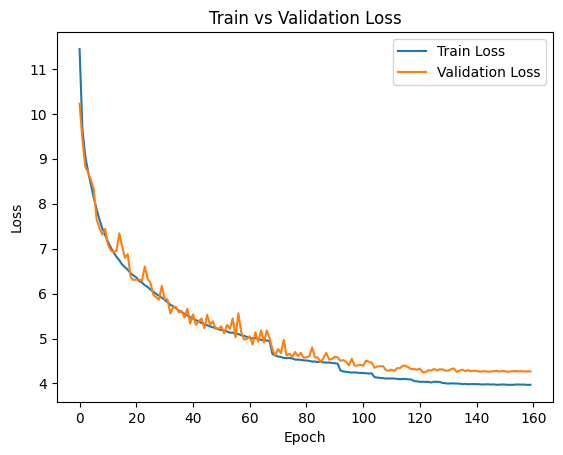

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Train vs Validation Loss')
# plt.show()


In [ ]:
# model.eval()
# all_preds = []
# all_targets = []

# with torch.no_grad():
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         outputs = model(X_batch)

#         all_preds.append(outputs.cpu())
#         all_targets.append(y_batch.cpu())

# # Concatenation des prédictions et cibles
# all_preds = torch.cat(all_preds, dim=0).numpy()
# all_targets = torch.cat(all_targets, dim=0).numpy()

# # Calcul des métriques
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# mse = mean_squared_error(all_targets, all_preds)
# mae = mean_absolute_error(all_targets, all_preds)
# r2 = r2_score(all_targets, all_preds)

# print("\n--- Test Metrics ---")
# print(f"MAE  (Mean Absolute Error): {mae:.4f}")
# print(f"MSE  (Mean Squared Error): {mse:.4f}")
# print(f"R²   (R-squared Score): {r2:.4f}")



--- Test Metrics ---
MAE  (Mean Absolute Error): 4.3537
MSE  (Mean Squared Error): 51.3083
R²   (R-squared Score): 0.8141


1. input_dim = 2
Pourquoi 2 ?
Tu veux traiter des séries temporelles où chaque timestep a 2 caractéristiques (features) — par exemple, température et humidité à chaque heure.

C'est ton choix selon ton dataset.

2. model_dim = 64
Pourquoi 64 ?
Dans Transformer, model_dim est la dimension interne des vecteurs après projection.

64 est un compromis courant : pas trop petit pour capter des patterns complexes, pas trop grand pour éviter trop de calculs et surapprentissage.

Souvent utilisé : 32, 64, 128 selon la taille du dataset.

3. num_heads = 4
Pourquoi 4 têtes ?

Chaque "head" permet au modèle de focaliser son attention sur différentes parties de la séquence.

Plus de têtes => plus de diversité d'attention, mais plus coûteux.

4 est raisonnable pour une dimension cachée de 64, car 64 ÷ 4 = 16 par tête (doit être divisible).

4. num_layers = 2
Pourquoi 2 couches ?
Le Transformer va encoder plus de complexité avec plus de couches.

Mais beaucoup de couches sur petits datasets = overfitting.

2 couches est suffisant pour commencer, simple et rapide à entraîner.

5. output_dim = 2
Pourquoi 2 ?

Ton objectif est de prédire 2 valeurs à chaque étape (par exemple prédire température ET humidité au prochain timestep).

Symétrique avec input_dim = 2.

6. Critère : nn.SmoothL1Loss()
Pourquoi Smooth L1 ?
C'est un compromis entre MSE (quadratique) et MAE (linéaire).

Plus robuste aux outliers que MSE.

Bon choix pour séries temporelles bruyantes ou avec valeurs extrêmes.

7. Optimiseur : Adam avec lr=0.0001
Pourquoi Adam ?
Adam est standard pour des Transformers : gère bien le bruit et adapte automatiquement les learning rates pour chaque paramètre.

Pourquoi 0.0001 ?
Transformers sont sensibles au learning rate.
Un LR trop haut (> 0.001) peut diverger facilement.
0.0001 est un safe starting point pour l'entraînement stable.

8. Scheduler : ReduceLROnPlateau
Pourquoi ReduceLROnPlateau ?
Si la perte n'améliore plus, il réduit automatiquement le learning rate.

Ça aide à mieux converger quand on approche d'un minimum.

9. Clipping du gradient : max_norm=1.0
Pourquoi clipper ?
Les Transformers peuvent avoir des explosions de gradient.

Clipper empêche ça et rend l'entraînement plus stable.

10. Batch size = 32
Pourquoi 32 ?

32 est un bon compromis entre vitesse et stabilité sur GPU.

Batchs plus grands (64, 128) peuvent être meilleurs si ton GPU a beaucoup de mémoire.